# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

We also need PyTorch ≥ 2.6.0:

In [3]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.6.0")

This chapter can be very slow without a hardware accelerator, so if we can find one, let's use it:

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'mps'

Let's issue a warning if there's no hardware accelerator available:

In [5]:
if device == "cpu":
    print("Neural nets can be very slow without a hardware accelerator.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Convolutional Layers
## Implementing Convolutional Layers with PyTorch

Let's load two sample images and convert them to a float tensor:

In [7]:
import numpy as np
import torch
from sklearn.datasets import load_sample_images

sample_images = np.stack(load_sample_images()["images"])
sample_images = torch.tensor(sample_images, dtype=torch.float32) / 255

Why convert to tensor?

PyTorch models work only with tensors, not NumPy arrays

	•	NumPy → for general computation
	•	PyTorch → for deep learning

Why use float32?

Neural networks need continuous values, not integers.
	•	Original pixels → integers (0–255)
	•	CNN uses weights, gradients → floating point.

Deep learning works with floating-point numbers for precise calculations.

Why divide by 255?

To normalize pixel values


In [8]:
sample_images.shape

torch.Size([2, 427, 640, 3])

Let's permute the dimensions from `[batch, height, width, channels]` to `[batch, channels, height, width]`, as PyTorch expects:

In [9]:
sample_images_permuted = sample_images.permute(0, 3, 1, 2)
sample_images_permuted.shape

torch.Size([2, 3, 427, 640])

Before: (batch, height, width, channels)

After : (batch, channels, height, width)

why?
PyTorch expects channels first.

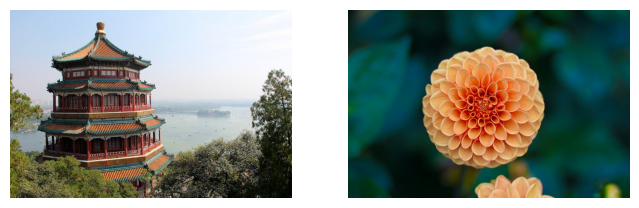

In [10]:
def plot_image(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

plt.figure(figsize=(8, 4))
for index, image in enumerate(sample_images_permuted):
    plt.subplot(1, 2, index + 1)
    plot_image(image)

Now let's rescale the pixel values from 0-255 to 0-1, and center crop them to small 70×120 images:

In [11]:
import torchvision
import torchvision.transforms.v2 as T

cropped_images = T.CenterCrop((70, 120))(sample_images_permuted)
cropped_images.shape

torch.Size([2, 3, 70, 120])

What is CenterCrop((70, 120))?
	•	Take a rectangle of height = 70 pixels
	•	Width = 120 pixels
	•	From the center of the image
If original image is: (3, 427, 640)
After cropping: (3, 70, 120)

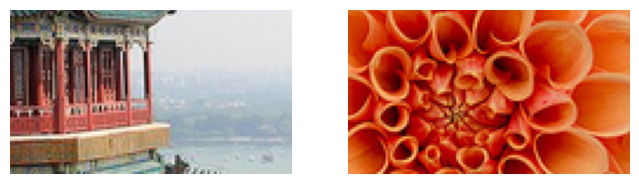

In [12]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_image(cropped_images[0])
plt.subplot(1, 2, 2)
plot_image(cropped_images[1])

In [13]:
import torch.nn as nn

torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7)
fmaps = conv_layer(cropped_images)

We apply 32 filters to each image to extract features like edges and patterns.
Each filter produces one feature map.
So:
	•	32 filters → 32 feature maps
Kernel size is the size of the filter (sliding window) used in convolution.
Think of kernel like a small window scanning the image:
Image
[...............]
[....####.......]
[....####.......]
[....####.......]

In [14]:
fmaps.shape

torch.Size([2, 32, 64, 114])


2 : Number of images
32 : Number of feature maps (filters)
64 : New height
114 : New width


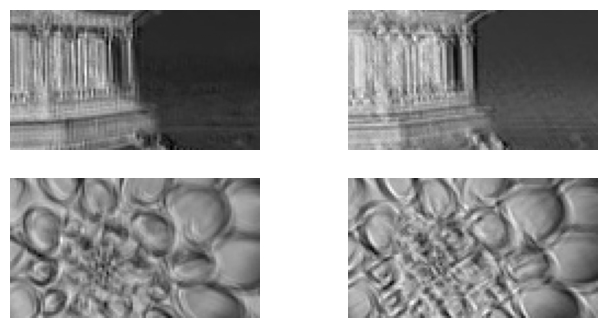

In [15]:
# extra code – displays the two output feature maps for each image

plt.figure(figsize=(8, 4))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, fmap_idx].detach(), cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

How one filter “sees” the image.
 Displays in grayscale
	•	Bright → strong feature
	•	Dark → weak feature

Now let's use zero-padding:

In [16]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7,
                       padding="same")
fmaps = conv_layer(cropped_images)

Why padding is used

Without padding:
	•	Image shrinks after convolution

With padding:
	•	Keeps size same
	•	Preserves edge information

In [17]:
fmaps.shape

torch.Size([2, 32, 70, 120])

In [18]:
# extra code – shows the output shape when we set strides=2
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2,
                       padding=3)
fmaps = conv_layer(cropped_images)
fmaps.shape

torch.Size([2, 32, 35, 60])

Stride controls how much the filter moves and reduces output size.
Instead of checking every pixel, we skip some pixels to make computation faster.

Let's now look at the shape of the parameters:

In [19]:
conv_layer.weight.shape

torch.Size([32, 3, 7, 7])

In [20]:
conv_layer.bias.shape

torch.Size([32])

# Pooling Layers
## Implementing Pooling Layers with PyTorch

**Max pooling**

In [22]:
max_pool = nn.MaxPool2d(kernel_size=2)

Takes maximum value from each 2×2 region

In [23]:
output_max = max_pool(cropped_images)

In [24]:
avg_pool = nn.AvgPool2d(kernel_size=2)

Takes average value from each 2×2 region

In [25]:
output_avg = avg_pool(cropped_images)

Max pooling keeps the most important information.
Average pooling gives a smoother representation.

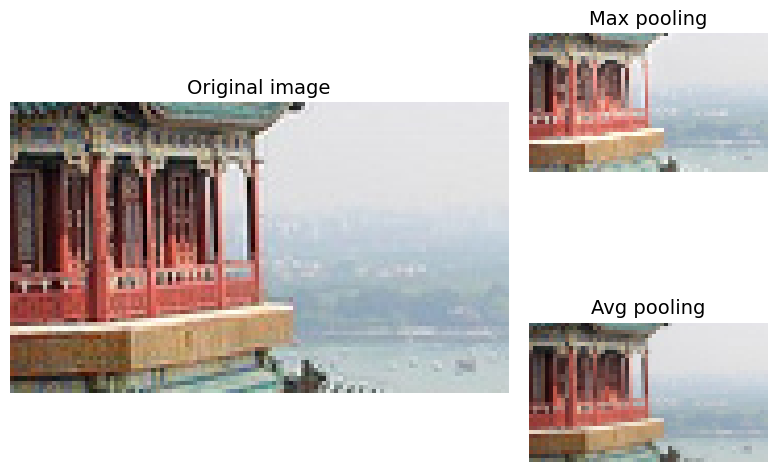

In [26]:
# extra code – this cells shows what max pooling with stride = 2 looks like

fig = plt.figure(figsize=(8, 6))

ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
ax1.imshow(cropped_images[0].permute(1, 2, 0))
ax1.axis('off')
ax1.set_title("Original image")

ax2 = plt.subplot2grid((2, 3), (0, 2))
ax2.imshow(output_max[0].permute(1, 2, 0))
ax2.axis('off')
ax2.set_title("Max pooling")

ax3 = plt.subplot2grid((2, 3), (1, 2))
ax3.imshow(output_avg[0].permute(1, 2, 0))
ax3.axis('off')
ax3.set_title("Avg pooling")

plt.tight_layout()
plt.show()

**Depth-wise pooling**

In [27]:
import torch.nn.functional as F

class DepthMaxPool2(torch.nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, inputs):
        batch, channels, height, width = inputs.shape
        Z = inputs.view(batch, channels, height * width)  # merge spatial dims
        Z = Z.permute(0, 2, 1)  # switch spatial and channels dims
        Z = F.max_pool1d(Z, kernel_size=self.kernel_size, stride=self.stride,
                         padding=self.padding)  # compute max pool
        Z = Z.permute(0, 2, 1)  # switch back spatial and channels dims
        return Z.view(batch, -1, height, width)  # unmerge spatial dims

**Global Average Pooling**

Global Average Pooling takes the average of all values in each feature map, reducing it to a single number.

	•	Converts (channels, height, width) → (channels)
	•	Each feature map → one value

In [28]:
global_avg_pool = nn.AvgPool2d(kernel_size=(70, 120))

In [29]:
output = global_avg_pool(cropped_images)

Second implementation (recommended):

In [30]:
global_avg_pool = nn.AdaptiveAvgPool2d(output_size=1)

In [31]:
output = global_avg_pool(cropped_images)

Third implementation, without using a module:

In [32]:
output = cropped_images.mean(dim=(2, 3), keepdim=True)

After global average pooling, feature maps become vectors, not images.